In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dotenv import dotenv_values
from matplotlib.colors import LogNorm
from census import Census
import contextily as cx

In [2]:
config = dotenv_values(".env")

In [3]:
c = Census(config["CENSUS_API_KEY"])

In [4]:
blocks = gpd.read_file("../data/joins/block_dissolve.shp.zip")
blocks["GEOID_grp"] = blocks["GEOID20"].apply(lambda s: s[:-3])
blocks["GEOID_tract"]= blocks["GEOID20"].apply(lambda s: s[:-4])

In [5]:
blocks.head(1)

,GEOID20,ALAND20,AWATER20,HOUSING20,POP20,osmid_x,tract_osmi,land_osmid,trip_time,RPT_AC,...,AC_5,AC_10,AC_15,AC_20,AC_30,AC_45,AC_60,geometry,GEOID_grp,GEOID_tract
0,230010101001000,0,1367280,0,0,219957146130,2.199571e+11,4.774280e+10,1095.0,244.177,...,1.345575,3.439989,0.0,0.764449,5.278893,160.676429,195.179691,"POLYGON ((-7817279.876 5480985.603, -7817233.9...",230010101001,23001010100


In [6]:
blocks.columns

Index(['GEOID20', 'ALAND20', 'AWATER20', 'HOUSING20', 'POP20', 'osmid_x',
       'tract_osmi', 'land_osmid', 'trip_time', 'RPT_AC', 'CALC_AC',
       'IUCN_STATU', 'CL_UNIQUEI', 'OBJECTID', 'ShapeSTAre', 'ShapeSTLen',
       'osmid_y', 'AC_5', 'AC_10', 'AC_15', 'AC_20', 'AC_30', 'AC_45', 'AC_60',
       'geometry', 'GEOID_grp', 'GEOID_tract'],
      dtype='object')

## Retrieving Census Variables
| **Name** | **Label**                                      | **Concept**                                            |
|----------|------------------------------------------------|--------------------------------------------------------|
| GEO_ID   | Geography                                      |                                                        |
| P1_001N  | !!Total:                                       | RACE                                                   |
| P1_003N  | !!Total:!!Population of one race:!!White alone | RACE                                                   |
| P2_001N  | !!Total:                                       | HISPANIC OR LATINO, AND NOT HISPANIC OR LATINO BY RACE |
| P2_002N  | !!Total:!!Hispanic or Latino                   | HISPANIC OR LATINO, AND NOT HISPANIC OR LATINO BY RACE |

In [7]:
me_census = pd.DataFrame.from_records(c.pl.state_county_block(fields=('GEO_ID', 'P1_001N', 'P1_003N', 'P2_001N', 'P2_002N'),
                                      state_fips = "23",
                                      county_fips = "*",
                                      blockgroup="*",
                                      block="*",
                                      year = 2020))
me_census["GEOID20"] = me_census["GEO_ID"].apply(lambda s: s[9:])

In [8]:
me_census.head(1)

,GEO_ID,P1_001N,P1_003N,P2_001N,P2_002N,state,county,tract,block,GEOID20
0,1000000US230010101001003,42.0,25.0,42.0,1.0,23,001,010100,1003,230010101001003


In [9]:
merge = blocks.merge(me_census, how="left", on="GEOID20")

In [10]:
merge.head(1)

,GEOID20,ALAND20,AWATER20,HOUSING20,POP20,osmid_x,tract_osmi,land_osmid,trip_time,RPT_AC,...,GEOID_tract,GEO_ID,P1_001N,P1_003N,P2_001N,P2_002N,state,county,tract,block
0,230010101001000,0,1367280,0,0,219957146130,2.199571e+11,4.774280e+10,1095.0,244.177,...,23001010100,1000000US230010101001000,0.0,0.0,0.0,0.0,23,001,010100,1000


In [11]:
merge["POPDENSE"] = merge["P1_001N"].astype(np.float64) / merge["ALAND20"].astype(np.float64)
merge["POPDENSE"].replace(np.inf, np.nan, inplace=True) # set infs to nan

Text(0.5, 1.0, 'Distribution of Block Populations')

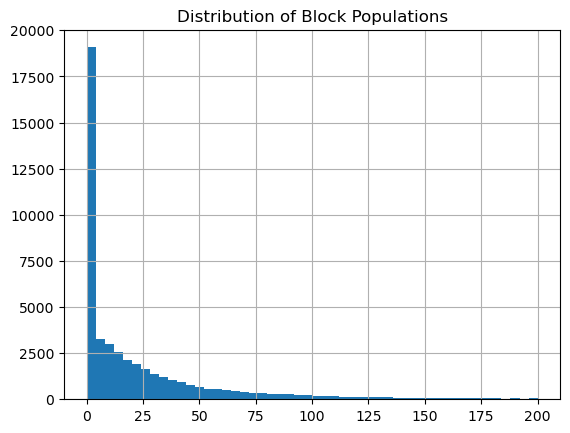

In [12]:
ax = merge.groupby("GEOID20").first()["P1_001N"].hist(range=(0,200), bins=50)
ax.set_title("Distribution of Block Populations")

Text(0.5, 1.0, 'Distribution of Block Population Densities')

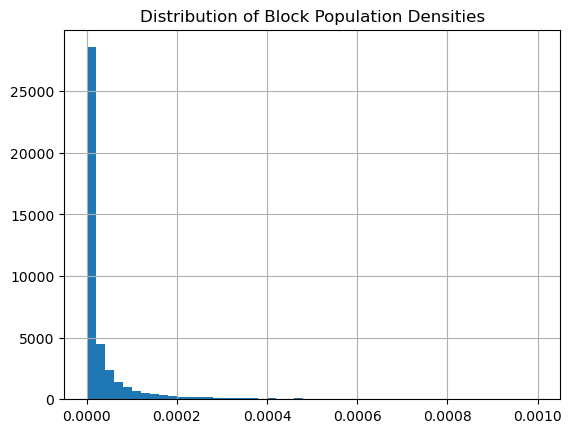

In [13]:
ax = merge.groupby("GEOID20").first()["POPDENSE"].hist(range=(0,0.001), bins=50)
ax.set_title("Distribution of Block Population Densities")

Text(0.5, 1.0, 'Population Density')

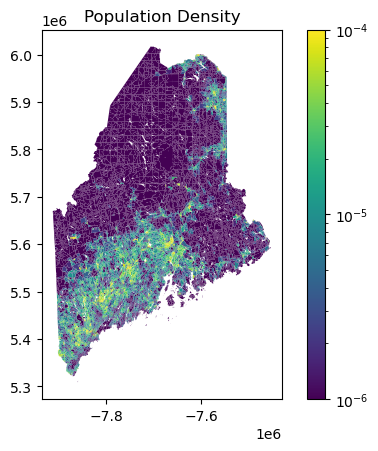

In [14]:
ax = merge.dropna(subset="POPDENSE").groupby("GEOID20").first().plot("POPDENSE", linewidth=0, legend=True, norm=LogNorm(1e-6, 1e-4, clip=True))
ax.set_title("Population Density")

In [15]:
dissolve = merge.dissolve(by="GEOID20", aggfunc='sum')

/home/philip/miniconda3/envs/ox/lib/python3.11/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [16]:
desc = dissolve[dissolve["AC_60"]>0]["AC_60"].describe()
desc

count     26910.000000
mean        919.235506
std        9193.248283
min           0.002483
25%          59.319117
50%         182.911409
75%         403.135752
max      355449.124220
Name: AC_60, dtype: float64

Text(0.5, 1.0, 'Acres of Conserved Land within 60 Minute Walk')

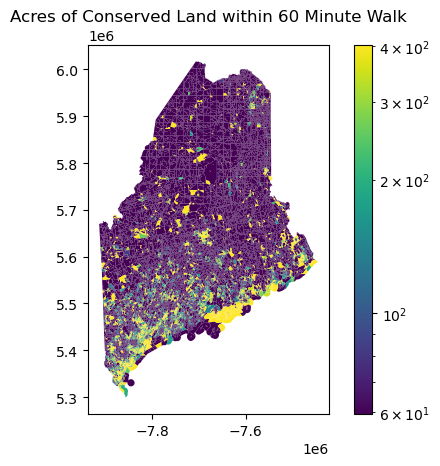

In [17]:
ax = dissolve.plot("AC_60", linewidth=0, legend=True, norm=LogNorm(desc["25%"], desc["75%"], clip=True))
ax.set_title("Acres of Conserved Land within 60 Minute Walk")

/home/philip/miniconda3/envs/ox/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'binwidth'
  cset = contour_func(


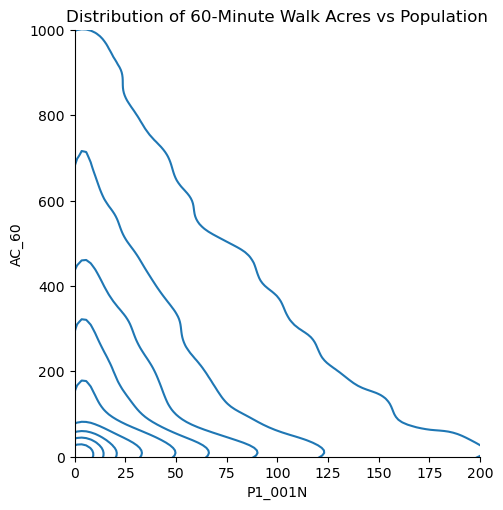

In [18]:
g = sns.displot(dissolve[(dissolve["AC_60"] < 1000) & (dissolve["P1_001N"] < 400) ], x="P1_001N", y="AC_60", binwidth=(5, 10), kind="kde")
g.set(xlim=(0,200))
g.set(ylim=(0,1000))
g.set(title="Distribution of 60-Minute Walk Acres vs Population")

/home/philip/miniconda3/envs/ox/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'binwidth'
  cset = contour_func(


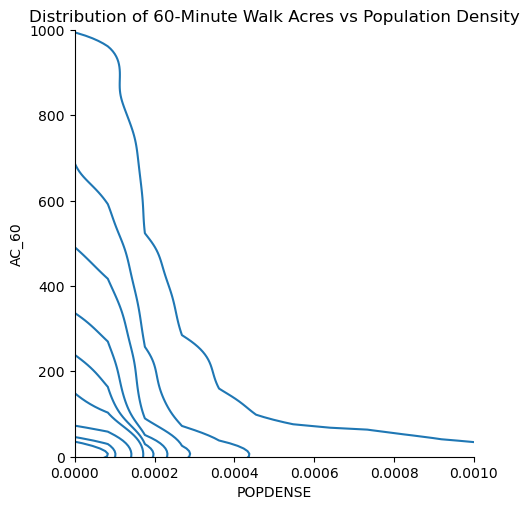

In [19]:
g = sns.displot(dissolve[(dissolve["AC_60"] < 1000) & (dissolve["POPDENSE"] > 0) ], x="POPDENSE", y="AC_60", binwidth=(5, 10), kind="kde")
g.set(xlim=(0,0.0010))
g.set(ylim=(0,1000))
g.set(title="Distribution of 60-Minute Walk Acres vs Population Density")

In [20]:
relationships = pd.read_csv("../data/tab2010_tab2020_st23_me.txt", delimiter="|", converters={
    "STATE_2010":str,
    "COUNTY_2010":str,
    "TRACT_2010":str,
    "BLK_2010":str,
    "BLKSF_2010":str,
    "AREALAND_2010":float,
    "AREAWATER_2010":float,
    "BLOCK_PART_FLAG_O":str,
    "STATE_2020":str,
    "COUNTY_2020":str,
    "TRACT_2020":str,
    "BLK_2020":str,
    "BLKSF_2020":str,
    "AREALAND_2020":float,
    "AREAWATER_2020":float,
    "BLOCK_PART_FLAG_R":str,
    "AREALAND_INT":float,
    "AREAWATER_INT":float
})
relationships["GEOID10"] = relationships["STATE_2010"]+relationships["COUNTY_2010"]+relationships["TRACT_2010"]
relationships["GEOID10_blk"] = relationships["STATE_2010"]+relationships["COUNTY_2010"]+relationships["TRACT_2010"]+relationships["BLK_2010"]
relationships["GEOID20"] = relationships["STATE_2020"]+relationships["COUNTY_2020"]+relationships["TRACT_2020"]+relationships["BLK_2020"]
relationships.head(1)

,STATE_2010,COUNTY_2010,TRACT_2010,BLK_2010,BLKSF_2010,AREALAND_2010,AREAWATER_2010,BLOCK_PART_FLAG_O,STATE_2020,COUNTY_2020,...,BLK_2020,BLKSF_2020,AREALAND_2020,AREAWATER_2020,BLOCK_PART_FLAG_R,AREALAND_INT,AREAWATER_INT,GEOID10,GEOID10_blk,GEOID20
0,23,001,010100,1000,,0.0,45576.0,,23,001,...,1000,,0.0,45576.0,,0.0,45576.0,23001010100,230010101001000,230010101001000


In [21]:
cejst = gpd.read_file("../data/cejst-me.zip", converters={"GEOID10": str})
cejst.head(1)

,GEOID10,SF,CF,DF_PFS,AF_PFS,HDF_PFS,DSF_PFS,EBF_PFS,EALR_PFS,EBLR_PFS,...,AGE_10,AGE_MIDDLE,AGE_OLD,TA_COU_116,TA_COUNT_C,TA_PERC,TA_PERC_FE,UI_EXP,THRHLD,geometry
0,23005002400,Maine,Cumberland County,0.25,0.57,0.62,0.2,0.8,0.16,0.47,...,0.04,0.61,0.34,NaN,NaN,NaN,NaN,Nation,21,"POLYGON ((-70.08518 43.70208, -70.08430 43.700..."


<AxesSubplot: xlabel='TC', ylabel='Count'>

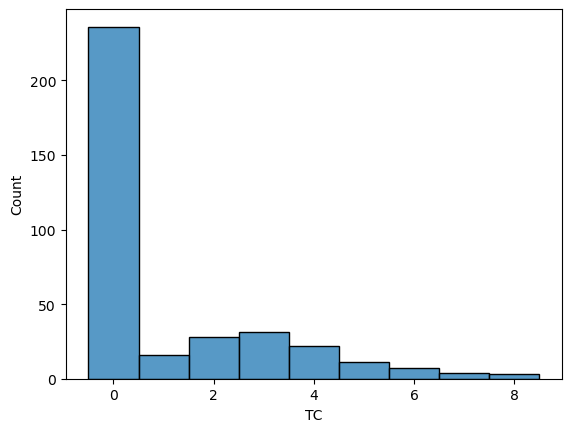

In [22]:
sns.histplot(cejst, x="TC", discrete=True)

In [23]:
print("Before:", cejst.shape)
cejst20 = relationships.merge(cejst, how="left", on="GEOID10")
cejst20["WEIGHT"] = (cejst20["AREALAND_INT"] + cejst20["AREAWATER_INT"]) / (cejst20["AREALAND_2020"]+cejst20["AREAWATER_2020"])
print("After:", cejst20.shape)

Before: (358, 124)
After: (78025, 145)


<AxesSubplot: xlabel='WEIGHT', ylabel='Count'>

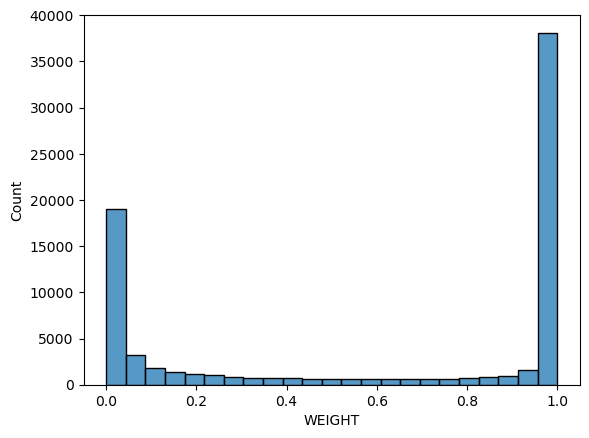

In [24]:
sns.histplot(cejst20, x="WEIGHT")

<AxesSubplot: xlabel='TC', ylabel='Count'>

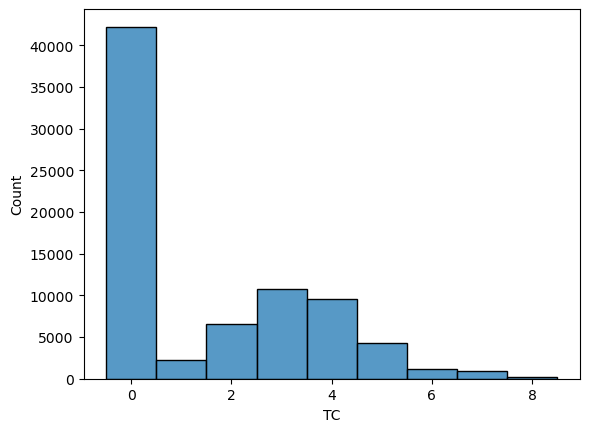

In [25]:
sns.histplot(cejst20, x="TC", discrete=True)

In [26]:
def w_avg(x):
    return int(np.ceil(np.average(x, weights=cejst20.loc[x.index, "WEIGHT"])))

In [27]:
print("Before:", cejst20.shape)
cejst_block = cejst20.groupby("GEOID20").agg({"TC":w_avg,"CC":w_avg})
print("After:", cejst_block.shape)

Before: (78025, 145)
After: (47138, 2)


<AxesSubplot: xlabel='TC', ylabel='Count'>

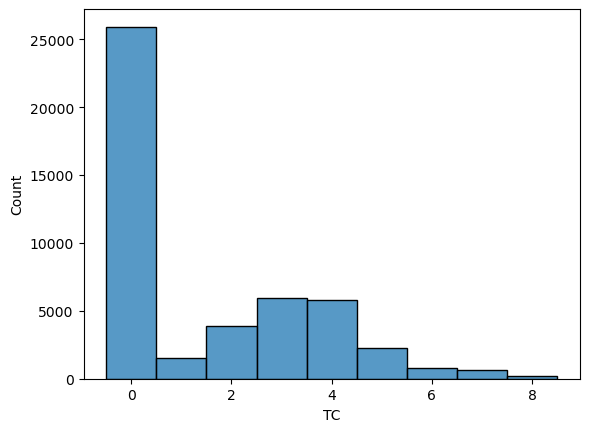

In [28]:
sns.histplot(cejst_block, x="TC", discrete=True)

In [29]:
print("Before:", merge.shape)
ejblocks = merge.merge(cejst_block, on="GEOID20")
print("After:", ejblocks.shape)
ejblocks.head(1)

Before: (47138, 37)
After: (47138, 39)


,GEOID20,ALAND20,AWATER20,HOUSING20,POP20,osmid_x,tract_osmi,land_osmid,trip_time,RPT_AC,...,P1_003N,P2_001N,P2_002N,state,county,tract,block,POPDENSE,TC,CC
0,230010101001000,0,1367280,0,0,219957146130,2.199571e+11,4.774280e+10,1095.0,244.177,...,0.0,0.0,0.0,23,001,010100,1000,NaN,8,4


In [30]:
ejblocks["white_per"] = ejblocks["P1_003N"] / ejblocks["P1_001N"]
ejblocks["hisp_per"] = ejblocks["P2_002N"] / ejblocks["P2_001N"]
ejblocks["white_50"] = ejblocks["white_per"] > ejblocks["white_per"].describe()["50%"]
ejblocks["hisp_75"] = ejblocks["hisp_per"] > ejblocks["hisp_per"].describe()["75%"]

<AxesSubplot: xlabel='TC', ylabel='CALC_AC'>

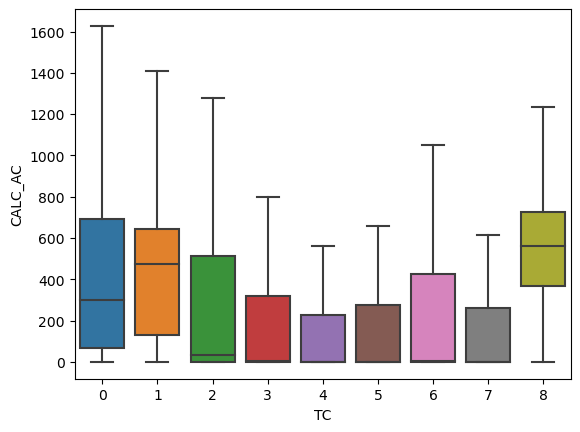

In [31]:
sns.boxplot(ejblocks, x="TC", y="CALC_AC", showfliers=False)

In [32]:
ejblocks.to_file("../data/joins/ejblocks.shp.zip")

/tmp/ipykernel_22143/639181491.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ejblocks.to_file("../data/joins/ejblocks.shp.zip")


Zero Inflated Poisson distribution

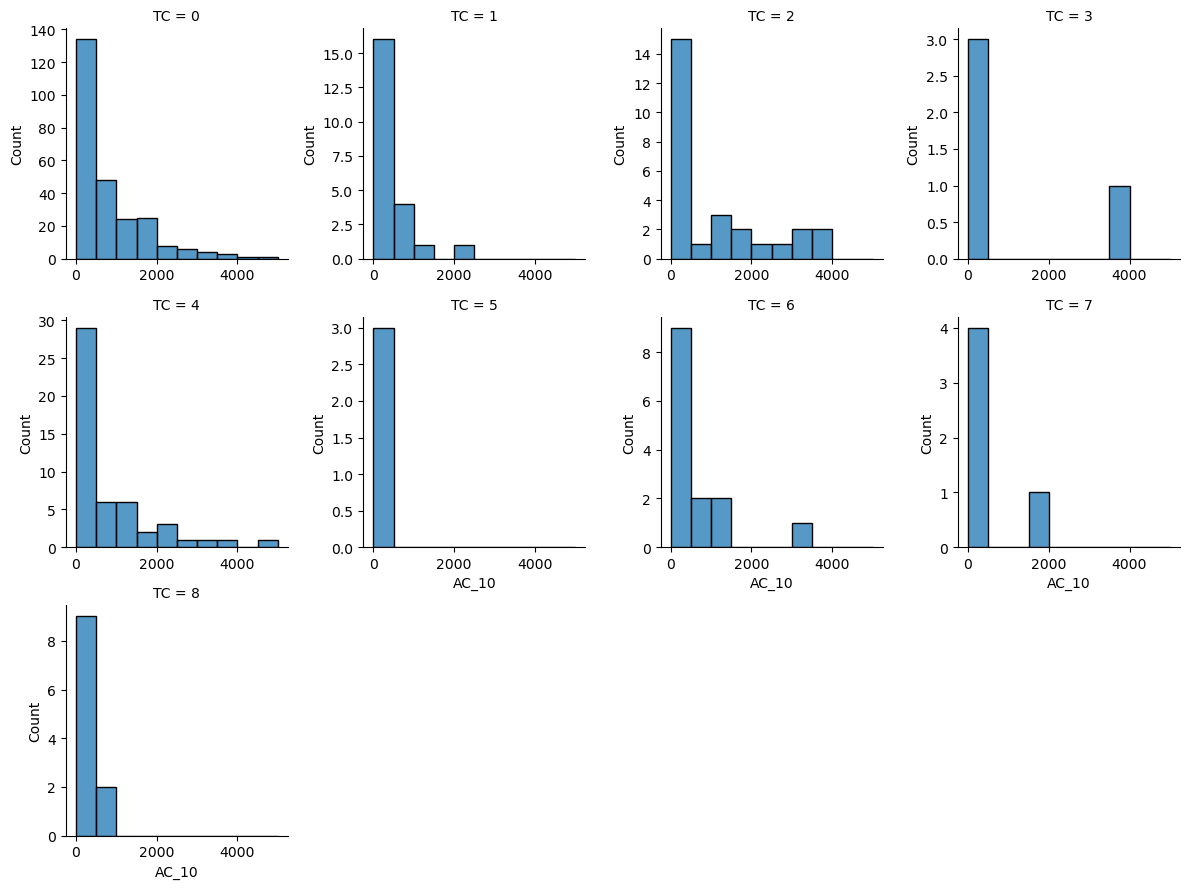

In [33]:
g = sns.FacetGrid(ejblocks.groupby("GEOID_tract").agg({"TC":"max", "AC_10":"sum"}), col="TC", col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, "AC_10", bins=10, binrange=[0,5e3])

Text(0.5, 1.0, 'CEJST Threshold Count')

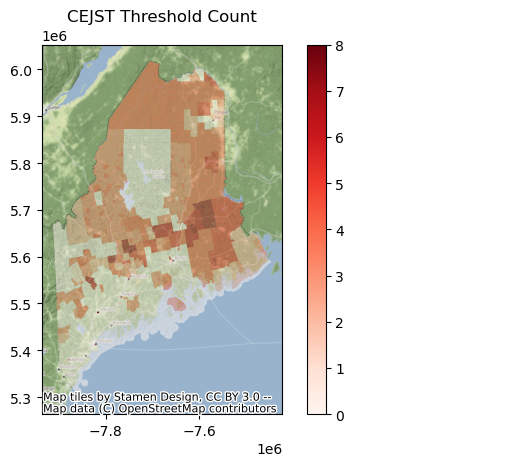

In [34]:
ax = ejblocks.plot("TC", cmap="Reds", legend=True, alpha=0.5)
cx.add_basemap(ax)
ax.set_title("CEJST Threshold Count")

Text(0.5, 1.0, '>50th Percentile White')

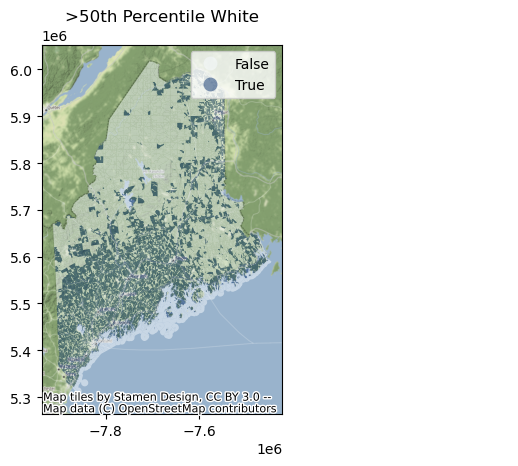

In [36]:
ax = ejblocks.plot("white_50", cmap="Blues", legend=True, alpha=0.5)
cx.add_basemap(ax)
ax.set_title(">50th Percentile White")